<a href="https://colab.research.google.com/github/leekate/2020ctrc/blob/master/new_classification_RESNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install dataset

     |████████████████████████████████| 163kB 11.5MB/s 
     |████████████████████████████████| 81kB 10.2MB/s 


# Data Load, Read

In [3]:

import os
import glob
import numpy as np
import cv2
from sklearn.utils import shuffle

def load_train(train_path, image_size, classes):
    images = []
    labels = []
    ids = []
    cls = []

    print('Reading training images')
    for fld in classes:
        index = classes.index(fld)
        print('Loading {} files (Index: {})'.format(fld, index))
        path = os.path.join(train_path, fld, '*g')
        files = glob.glob(path)
        for fl in files:
            image = cv2.imread(fl)
            image = cv2.resize(image, (image_size, image_size), cv2.INTER_LINEAR)
            images.append(image)
            label = np.zeros(len(classes))
            label[index] = 1.0
            labels.append(label)
            flbase = os.path.basename(fl)
            ids.append(flbase)
            cls.append(fld)
    images = np.array(images)
    labels = np.array(labels)
    ids = np.array(ids)
    cls = np.array(cls)
  

    return images, labels, ids, cls


def load_test(test_path, image_size):
    path = os.path.join(test_path, '*g')
    files = sorted(glob.glob(path))

    X_test = []
    X_test_id = []
    print("Reading test images")
    for fl in files:
        
        img = cv2.imread(fl)
        img = cv2.resize(img, (image_size, image_size), cv2.INTER_LINEAR)
        X_test.append(img)
        X_test_id.append(flbase)
        flbase = os.path.basename(fl)

    X_test = np.array(X_test, dtype=np.uint8)
    X_test = X_test.astype('float32')
    X_test = X_test / 255
    X_test_id = np.array(X_test_id)

    return X_test, X_test_id


class DataSet(object):

    def __init__(self, images, labels, ids, cls):
        """Construct a DataSet. one_hot arg is used only if fake_data is true."""

        self._num_examples = images.shape[0]

        # Convert shape from [num examples, rows, columns, depth]
        # to [num examples, rows*columns] (assuming depth == 1)
        # Convert from [0, 255] -> [0.0, 1.0].

        images = images.astype(np.float32)
        images = np.multiply(images, 1.0 / 255.0)

        self._images = images
        self._labels = labels
        self._ids = ids
        self._cls = cls
        self._epochs_completed = 0
        self._index_in_epoch = 0

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def ids(self):
        return self._ids

    @property
    def cls(self):
        return self._cls

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def epochs_completed(self):
        return self._epochs_completed

    def next_batch(self, batch_size):
        """Return the next `batch_size` examples from this data set."""
        start = self._index_in_epoch
        self._index_in_epoch += batch_size

        if self._index_in_epoch > self._num_examples:
            # Finished epoch
            self._epochs_completed += 1

            # # Shuffle the data (maybe)
            # perm = np.arange(self._num_examples)
            # np.random.shuffle(perm)
            # self._images = self._images[perm]
            # self._labels = self._labels[perm]
            # Start next epoch

            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch

        return self._images[start:end], self._labels[start:end], self._ids[start:end], self._cls[start:end]


def read_train_sets(train_path, image_size, classes, validation_size=0):
    class DataSets(object):
        pass

    data_sets = DataSets()

    images, labels, ids, cls = load_train(train_path, image_size, classes)
    images, labels, ids, cls = shuffle(images, labels, ids, cls)  # shuffle the data

    if isinstance(validation_size, float):
        validation_size = int(validation_size * images.shape[0])

    train_images = images
    train_labels = labels
    train_ids = ids
    train_cls = cls

    data_sets.train = DataSet(train_images, train_labels, train_ids, train_cls)

    return data_sets

In [4]:
def load_validation(validation_path, image_size, classes):
    images2 = []
    labels2 = []
    ids2 = []
    cls2 = []

    print('Reading validation images')
    for fld in classes:
        index = classes.index(fld)
        print('Loading {} files (Index: {})'.format(fld, index))
        path = os.path.join(validation_path, fld, '*g')
        files = glob.glob(path)
        for fl in files:
            image = cv2.imread(fl)
            image = cv2.resize(image, (image_size, image_size), cv2.INTER_LINEAR)
            images2.append(image)
            label = np.zeros(len(classes))
            label[index] = 1.0
            labels2.append(label)
            flbase = os.path.basename(fl)
            ids2.append(flbase)
            cls2.append(fld)
    images2 = np.array(images2)
    labels2 = np.array(labels2)
    ids2 = np.array(ids2)
    cls2 = np.array(cls2)
  

    return images2, labels2, ids2, cls2


def read_validation_sets(validation_path, image_size, classes, validation_size=0):
    class DataSets(object):
        pass

    data_sets = DataSets()

    images2, labels2, ids2, cls2 = load_validation(validation_path, image_size, classes)
    images2, labels2, ids2, cls2 = shuffle(images2, labels2, ids2, cls2)  # shuffle the data

    if isinstance(validation_size, float):
        validation_size = int(validation_size * images2.shape[0])

    validation_images = images2
    validation_labels = labels2
    validation_ids = ids2
    validation_cls = cls2

    data_sets.valid = DataSet(validation_images, validation_labels, validation_ids, validation_cls)

    return data_sets

In [5]:
def load_test(test_path, image_size, classes):
    images3 = []
    labels3 = []
    ids3 = []
    cls3 = []

    print('Reading validation images')
    for fld in classes:
        index = classes.index(fld)
        print('Loading {} files (Index: {})'.format(fld, index))
        path = os.path.join(test_path, fld, '*g')
        files = glob.glob(path)
        for fl in files:
            image = cv2.imread(fl)
            image = cv2.resize(image, (image_size, image_size), cv2.INTER_LINEAR)
            images3.append(image)
            label = np.zeros(len(classes))
            label[index] = 1.0
            labels3.append(label)
            flbase = os.path.basename(fl)
            ids3.append(flbase)
            cls3.append(fld)
    images3 = np.array(images3)
    labels3 = np.array(labels3)
    ids3 = np.array(ids3)
    cls3 = np.array(cls3)
  

    return images3, labels3, ids3, cls3


def read_test_sets(test_path, image_size, classes, validation_size=0):
    class DataSets(object):
        pass

    data_sets = DataSets()

    images3, labels3, ids3, cls3 = load_test(test_path, image_size, classes)
    images3, labels3, ids3, cls3 = shuffle(images3, labels3, ids3, cls3)  # shuffle the data

    if isinstance(validation_size, float):
        validation_size = int(validation_size * images3.shape[0])

    test_images = images3
    test_labels = labels3
    test_ids = ids3
    test_cls = cls3

    data_sets.test = DataSet(test_images, test_labels, test_ids, test_cls)

    return data_sets

In [6]:
import time
import math
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
import cv2
import dataset
import os
import keras

from sklearn.metrics import confusion_matrix
from datetime import timedelta
import seaborn as sn

%matplotlib inline

tf.disable_v2_behavior()

#######################################################################

filter_size1 = 7
num_filters1 = 64

filter_size2 = 1
num_filters2 = 64

filter_size3 = 3
num_filters3 = 64

filter_size4 = 1
num_filters4 = 256

filter_size5 = 1
num_filters5 = 128

filter_size6 = 3
num_filters6 = 128

filter_size7 = 1
num_filters7 = 512

filter_size8 = 1
num_filters8 = 256

filter_size9 = 3
num_filters9 = 256

filter_size10 = 1
num_filters10 = 1024

filter_size11 = 1
num_filters11 = 512

filter_size12 = 3
num_filters12 = 512

filter_size13 = 1
num_filters13 = 2048

#######################################################################

# Fully-connected layer.
# Number of neurons in fully-connected layer.
# convolution layer 전체에 있는 뉴런 수 = 필터 역할
# fc_size = 256             
fc_size = 1000


# Number of color channels for the images: 1 channel for gray-scale.
num_channels = 3

# image dimensions (only squares for now)
img_size = 224


#이전 층으로부터 받은 데이터에 대해 
#뉴런의 수만큼 해당되는 영역만큼 합성곱을 진행, 반복


# Size of image when flattened to a single dimension
img_size_flat = img_size * img_size * num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# class info
classes = ['1.Cancer', '2.Precancer', '3.Inflammatory', '4.Normal']
num_classes = len(classes)

# batch size
batch_size = 32

# # validation split
# validation_size = .2

# how long to wait after validation loss stops improving before terminating training
early_stopping = None  # use None if you don't want to implement early stoping

Instructions for updating:
non-resource variables are not supported in the long term


In [7]:

#######################################################################
# 공유드라이브 주소로 수정
train_path = '/content/drive/Shareddrives/CTRC/train2'
validation_path = '/content/drive/Shareddrives/CTRC/validation2'
test_path = '/content/drive/Shareddrives/CTRC/test2'
checkpoint_dir = '/content/drive/My Drive/CTRC/RESNET/model'


#######################################################################

# data = read_train_sets(train_path, img_size, classes, validation_size=validation_size)
# data2 = read_validation_sets(validation_path, img_size, classes, validation_size=validation_size)
# data3 = read_test_sets(test_path, img_size, classes, validation_size=validation_size)

data = read_train_sets(train_path, img_size, classes, validation_size=0)
data2 = read_validation_sets(validation_path, img_size, classes, validation_size=0)
data3 = read_test_sets(test_path, img_size, classes, validation_size=0)


print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Validation-set:\t{}".format(len(data2.valid.labels)))
print("- Test-set:\t\t{}".format(len(data3.test.labels)))

Reading training images
Loading 1.Cancer files (Index: 0)
Loading 2.Precancer files (Index: 1)
Loading 3.Inflammatory files (Index: 2)
Loading 4.Normal files (Index: 3)
Reading validation images
Loading 1.Cancer files (Index: 0)
Loading 2.Precancer files (Index: 1)
Loading 3.Inflammatory files (Index: 2)
Loading 4.Normal files (Index: 3)
Reading validation images
Loading 1.Cancer files (Index: 0)
Loading 2.Precancer files (Index: 1)
Loading 3.Inflammatory files (Index: 2)
Loading 4.Normal files (Index: 3)
Size of:
- Training-set:		4038
- Validation-set:	392
- Test-set:		392


In [8]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    #tf.truncated_normal: 너무 작거나 너무 큰 값이 아닌 값으로 랜덤한 값을 가져오는 것

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [9]:
def new_conv_layer(input,              
                   num_input_channels, 
                   filter_size,       
                   num_filters,       
                   use_pooling=True): 

    shape = [filter_size, filter_size, num_input_channels, num_filters]

    weights = new_weights(shape=shape)

    biases = new_biases(length=num_filters)

    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    layer += biases

    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    layer += biases

    if use_pooling:

        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    layer = tf.nn.relu(layer)


    return layer, weights

def new_conv_layer_drop(input,              
                   num_input_channels, 
                   filter_size,       
                   num_filters,       
                   use_pooling=True): 

    shape = [filter_size, filter_size, num_input_channels, num_filters]

    weights = new_weights(shape=shape)

    biases = new_biases(length=num_filters)

    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    layer += biases

    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    layer += biases

    if use_pooling:

        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    layer = tf.nn.relu(layer)
    layer = tf.nn.dropout(layer, keep_prob=keep_prob)
    
    return layer, weights


def flatten_layer(layer):

    layer_shape = layer.get_shape()

    num_features = layer_shape[1:8].num_elements()
    
    layer_flat = tf.reshape(layer, [-1, num_features])

    return layer_flat, num_features

  
def new_fc_layer(input,        
                 num_inputs,    
                 num_outputs,  
                 use_relu=True):

    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    layer = tf.matmul(input, weights) + biases
    
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer



x = tf.compat.v1.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

y_true = tf.compat.v1.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

y_true_cls = tf.argmax(y_true, axis=1)

keep_prob = tf.compat.v1.placeholder(tf.float32)

In [10]:
#######################################################################\
layer_conv1, weights_conv1 = \
    new_conv_layer_drop(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)
     
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)
    
layer_conv3, weights_conv3 = \
    new_conv_layer_drop(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True)
    
layer_conv4, weights_conv4 = \
    new_conv_layer(input=layer_conv3,
                   num_input_channels=num_filters3,
                   filter_size=filter_size4,
                   num_filters=num_filters4,
                   use_pooling=True)
    
layer_conv5, weights_conv5 = \
    new_conv_layer_drop(input=layer_conv4,
                   num_input_channels=num_filters4,
                   filter_size=filter_size5,
                   num_filters=num_filters5,
                   use_pooling=True)
    
layer_conv6, weights_conv6 = \
    new_conv_layer(input=layer_conv5,
                   num_input_channels=num_filters5,
                   filter_size=filter_size6,
                   num_filters=num_filters6,
                   use_pooling=True)
    
layer_conv7, weights_conv7 = \
    new_conv_layer_drop(input=layer_conv6,
                   num_input_channels=num_filters6,
                   filter_size=filter_size7,
                   num_filters=num_filters7,
                   use_pooling=True)

layer_conv8, weights_conv8 = \
    new_conv_layer_drop(input=layer_conv7,
                   num_input_channels=num_filters7,
                   filter_size=filter_size8,
                   num_filters=num_filters8,
                   use_pooling=True)
     
layer_conv9, weights_conv9 = \
    new_conv_layer(input=layer_conv8,
                   num_input_channels=num_filters8,
                   filter_size=filter_size9,
                   num_filters=num_filters9,
                   use_pooling=True)
    
layer_conv10, weights_conv10 = \
    new_conv_layer_drop(input=layer_conv9,
                   num_input_channels=num_filters9,
                   filter_size=filter_size10,
                   num_filters=num_filters10,
                   use_pooling=True)
    
layer_conv11, weights_conv11 = \
    new_conv_layer(input=layer_conv10,
                   num_input_channels=num_filters10,
                   filter_size=filter_size11,
                   num_filters=num_filters11,
                   use_pooling=True)
    
layer_conv12, weights_conv12 = \
    new_conv_layer_drop(input=layer_conv11,
                   num_input_channels=num_filters11,
                   filter_size=filter_size12,
                   num_filters=num_filters12,
                   use_pooling=True)
    
layer_conv13, weights_conv13 = \
    new_conv_layer(input=layer_conv12,
                   num_input_channels=num_filters12,
                   filter_size=filter_size13,
                   num_filters=num_filters13,
                   use_pooling=True)



layer_flat, num_features = flatten_layer(layer_conv13)



layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=128,
                         use_relu=False)

layer_fc3 = new_fc_layer(input=layer_fc2,
                         num_inputs=128,
                         num_outputs=num_classes,
                         use_relu=False)

'''layer_fc4 = new_fc_layer(input=layer_fc3,
                         num_inputs=64,
                         num_outputs=32,
                         use_relu=False)

layer_fc5 = new_fc_layer(input=layer_fc4,
                         num_inputs=32,
                         num_outputs=16,
                         use_relu=False)

layer_fc6 = new_fc_layer(input=layer_fc5,
                         num_inputs=16,
                         num_outputs=num_classes,                        
                         use_relu=False)'''

#######################################################################


y_pred = tf.nn.softmax(layer_fc3)

y_pred_cls = tf.argmax(y_pred, axis=1)

loss_func = tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc3, labels=y_true)

cost = tf.reduce_mean(loss_func)

regularizer = tf.nn.l2_loss(weights_conv13)
beta = 0.001
cost = tf.reduce_mean(cost + beta*regularizer)

optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

correct_prediction = tf.equal(y_pred_cls, y_true_cls)

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from yellowbrick.classifier import ROCAUC

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


각 epoch당 학습 결과 표시

In [12]:
session = tf.Session()

session.run(tf.global_variables_initializer())

train_batch_size = batch_size

save_dir="/content/drive/Shareddrives/CTRC/model"

def print_progress(epoch, feed_dict_train, val_loss):
    acc = session.run(accuracy, feed_dict=feed_dict_train)
    msg = "Epoch {0} --- Training Accuracy: {1:>6.1%},  Validation Loss: {2:.3f}"
    os.path.join(save_dir, "epoch{epoch:03d}_valloss{val_loss:0.4f}.hdf5")
    print(msg.format(epoch + 1, acc, val_loss))

    if epoch <= 47:
      print(print_validation_accuracy(show_confusion_matrix=False))
      print(print_test_accuracy(show_confusion_matrix=False))
    else:
      print(print_validation_accuracy(show_confusion_matrix=True))
      print(print_test_accuracy(show_confusion_matrix=True))


total_iterations = 0

train data 학습

In [13]:
def optimize(num_iterations):
    global total_iterations
    

    start_time = time.time()
    
    best_val_loss = float("inf")
    patience = 0

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        

        x_batch, y_true_batch, _, cls_batch = data.train.next_batch(train_batch_size)
        x_valid_batch, y_valid_batch, _, valid_cls_batch = data2.valid.next_batch(train_batch_size)
        x_test_batch, y_test_batch, _, test_cls_batch = data3.test.next_batch(train_batch_size)

        x_batch = x_batch.reshape(train_batch_size, img_size_flat)
        x_valid_batch = x_valid_batch.reshape(train_batch_size, img_size_flat)
        x_test_batch = x_test_batch.reshape(train_batch_size, img_size_flat)

        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch, keep_prob: 0.70}
        
        feed_dict_validate = {x: x_valid_batch,
                              y_true: y_valid_batch, keep_prob : 0.70}

        feed_dict_test = {x: x_test_batch,
                          y_true: y_test_batch, keep_prob : 0.70}

        session.run(optimizer, feed_dict=feed_dict_train)
        
        if i % int(data.train.num_examples/batch_size) == 0: 
            val_loss = session.run(cost, feed_dict=feed_dict_validate)
            epoch = int(i / int(data.train.num_examples/batch_size))

            print_progress(epoch, feed_dict_train, val_loss)
            
            if early_stopping:    
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience = 0
                else:
                    patience += 1

                if patience == early_stopping:
                    break


    total_iterations += num_iterations

    end_time = time.time()

    time_dif = end_time - start_time

    print("Time elapsed: " + str(timedelta(seconds=int(round(time_dif)))))

validation accuracy

In [14]:
def print_validation_accuracy(show_example_errors=False, show_confusion_matrix=False):

    num_test = len(data2.valid.images)

    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    i = 0

    while i < num_test:
 
        j = min(i + batch_size, num_test)

        images = data2.valid.images[i:j, :].reshape(-1, img_size_flat)
        
        labels = data2.valid.labels[i:j, :]

        feed_dict = {x: images, y_true: labels, keep_prob: 0.70}

        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        i = j


    cls_true = np.array(data2.valid.cls)
    cls_pred = np.array([classes[x] for x in cls_pred])

 

    correct = (cls_true == cls_pred)

    correct_sum = correct.sum()

    acc = float(correct_sum) / num_test

    msg = "Validation Accuracy: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

test accuracy

In [15]:
def print_test_accuracy(show_example_errors=False, show_confusion_matrix=False):

    num_test2 = len(data3.test.images)

    cls_pred2 = np.zeros(shape=num_test2, dtype=np.int)

    i = 0

    while i < num_test2:
 
        j = min(i + batch_size, num_test2)

        images = data3.test.images[i:j, :].reshape(-1, img_size_flat)
        
        labels = data3.test.labels[i:j, :]

        feed_dict = {x: images, y_true: labels, keep_prob: 0.70}

        cls_pred2[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        i = j


    cls_true2 = np.array(data3.test.cls)
    cls_pred2 = np.array([classes[x] for x in cls_pred2])

 

    correct = (cls_true2 == cls_pred2)

    correct_sum = correct.sum()

    acc = float(correct_sum) / num_test2

    msg = "Test Accuracy: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test2))

    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred2=cls_pred2, correct=correct)

    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix2(cls_pred2=cls_pred2)

In [16]:
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import roc_curve

혼동 행렬 1 (validation)

In [17]:
def plot_confusion_matrix(cls_pred):
    
    cls_true = data2.valid.cls

    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)
    
    print(cm)
    
    plt.matshow(cm, cmap=plt.cm.Wistia_r)

    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))

    plt.xlabel('Predicted')
    plt.ylabel('True')
    for i in range(0,4):
      for j in range(0,4):
        plt.text(j,i,str(cm[i][j]))
    plt.show()

    print("1.Cancer의 정밀도 : ", (cm[0,0]/(cm[0,0]+cm[1,0]+cm[2,0]+cm[3,0]))*100, "%")
    print("1.Cancer의 재현율 : ", (cm[0,0]/(cm[0,0]+cm[0,1]+cm[0,2]+cm[0,3]))*100, "%")
    print("2.Precancer의 정밀도 : ", (cm[1,1]/(cm[0,1]+cm[1,1]+cm[2,1]+cm[3,1]))*100, "%")
    print("2.Precancer의 재현율 : ", (cm[1,1]/(cm[1,0]+cm[1,1]+cm[1,2]+cm[1,3]))*100, "%")
    print("3.Inflammatory의 정밀도 : ", (cm[2,2]/(cm[0,2]+cm[1,2]+cm[2,2]+cm[3,2]))*100, "%")
    print("3.Inflammatory의 재현율 : ", (cm[2,2]/(cm[2,0]+cm[2,1]+cm[2,2]+cm[2,3]))*100, "%")
    print("4.Normal의 정밀도 : ", (cm[3,3]/(cm[0,3]+cm[1,3]+cm[2,3]+cm[3,3]))*100, "%")
    print("4.Normal의 재현율 : ", (cm[3,3]/(cm[3,0]+cm[3,1]+cm[3,2]+cm[3,3]))*100, "%")

혼동 행렬 2 + ROC (test)

In [18]:
def plot_confusion_matrix2(cls_pred2):
    
    cls_true2 = data3.test.cls

    cm = confusion_matrix(y_true=cls_true2, y_pred=cls_pred2)
    
    print(cm)
    
    plt.matshow(cm, cmap=plt.cm.Wistia_r)

    plt.colorbar()
    
    plt.title('Test Confusion Matrix')
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.grid(False)

    plt.xlabel('Predicted')
    plt.ylabel('True')
    for i in range(0,4):
      for j in range(0,4):
        plt.text(j,i,str(cm[i][j]))
    plt.show()

    print("1.Cancer의 정밀도 : ", (cm[0,0]/(cm[0,0]+cm[1,0]+cm[2,0]+cm[3,0]))*100, "%")
    print("1.Cancer의 재현율 : ", (cm[0,0]/(cm[0,0]+cm[0,1]+cm[0,2]+cm[0,3]))*100, "%")
    print("2.Precancer의 정밀도 : ", (cm[1,1]/(cm[0,1]+cm[1,1]+cm[2,1]+cm[3,1]))*100, "%")
    print("2.Precancer의 재현율 : ", (cm[1,1]/(cm[1,0]+cm[1,1]+cm[1,2]+cm[1,3]))*100, "%")
    print("3.Inflammatory의 정밀도 : ", (cm[2,2]/(cm[0,2]+cm[1,2]+cm[2,2]+cm[3,2]))*100, "%")
    print("3.Inflammatory의 재현율 : ", (cm[2,2]/(cm[2,0]+cm[2,1]+cm[2,2]+cm[2,3]))*100, "%")
    print("4.Normal의 정밀도 : ", (cm[3,3]/(cm[0,3]+cm[1,3]+cm[2,3]+cm[3,3]))*100, "%")
    print("4.Normal의 재현율 : ", (cm[3,3]/(cm[3,0]+cm[3,1]+cm[3,2]+cm[3,3]))*100, "%")

    
    cls_true2 = cls_true2.tolist()
    cls_pred2 = cls_pred2.tolist()

    real_true1 = []
    real_pred1 = []

    real_true2 = []
    real_pred2 = []

    real_true3 = []
    real_pred3 = []

    real_true4 = []
    real_pred4 = []

    i=0
    j=0
    k=0
    l=0

    for i in range(len(cls_true2)):
      if cls_true2[i] == "1.Cancer":
        real_true1.append(1)
        if cls_true2[i] == cls_pred2[i]:
          real_pred1.append(1)
        else:
          real_pred1.append(0)


    for j in range(len(cls_true2)):
      if cls_true2[j] == "1.Cancer":
        real_true2.append(1)
        if cls_true2[j] == cls_pred2[j]:
          real_pred2.append(1)
        else:
          real_pred2.append(0)


    for k in range(len(cls_true2)):
      if cls_true2[k] == "1.Cancer":
        real_true3.append(1)
        if cls_true2[k] == cls_pred2[k]:
          real_pred3.append(1)
        else:
          real_pred3.append(0)
   

    for l in range(len(cls_true2)):
      if cls_true2[l] == "1.Cancer":
        real_true4.append(1)
        if cls_true2[l] == cls_pred2[l]:
          real_pred4.append(1)
        else:
          real_pred4.append(0)
    

    real_true1 = np.array(real_true1)
    real_pred1 = np.array(real_pred1)

    real_true2 = np.array(real_true2)
    real_pred2 = np.array(real_pred2)

    real_true3 = np.array(real_true3)
    real_pred3 = np.array(real_pred3)

    real_true4 = np.array(real_true4)
    real_pred4 = np.array(real_pred4)


    print( "Cancer_roc_auc : ", roc_auc_score(real_true1, real_pred1, multi_class='ovr', average='micro'))
    print( "Precancer_roc_auc : ", roc_auc_score(real_true2, real_pred2, multi_class='ovr', average='micro'))
    print( "Inflammatory_roc_auc : ", roc_auc_score(real_true3, real_pred3, multi_class='ovr', average='micro'))
    print( "Normal_roc_auc : ", roc_auc_score(real_true4, real_pred4, multi_class='ovr', average='micro'))


    can = roc_auc_score(real_true1, real_pred1, multi_class='ovr', average='micro')
    pre = roc_auc_score(real_true2, real_pred2, multi_class='ovr', average='micro')
    inf = roc_auc_score(real_true3, real_pred3, multi_class='ovr', average='micro')
    nor = roc_auc_score(real_true4, real_pred4, multi_class='ovr', average='micro')



    fpr1, tpr1, threshold1 = roc_curve(real_true1, real_pred1)
    fpr2, tpr2, threshold2 = roc_curve(real_true2, real_pred2)
    fpr3, tpr3, threshold3 = roc_curve(real_true3, real_pred3)
    fpr4, tpr4, threshold4 = roc_curve(real_true4, real_pred4)


    plt.plot(fpr1, tpr1, '-', label="Cancer ROC Curve = %f"%(can), color='r')
    plt.plot(fpr2, tpr2, '-', label="Precancer ROC Curve = %f"%(pre), color='m')
    plt.plot(fpr3, tpr3, '-', label="Inflammatory ROC Curve = %f"%(inf), color='g')
    plt.plot(fpr4, tpr4, '-', label="Normal ROC Curve = %f"%(nor), color='b')
    plt.plot([0,1],[0,1], 'k--')
    plt.axis([0,1,0,1])

    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.legend(loc='lower right')
    plt.show()

실행

Epoch 1 --- Training Accuracy:  46.9%,  Validation Loss: 2.225
Validation Accuracy: 57.1% (224 / 392)
None
Test Accuracy: 54.8% (215 / 392)
None
Epoch 2 --- Training Accuracy:  46.9%,  Validation Loss: 2.104
Validation Accuracy: 57.9% (227 / 392)
None
Test Accuracy: 57.9% (227 / 392)
None
Epoch 3 --- Training Accuracy:  46.9%,  Validation Loss: 1.641
Validation Accuracy: 57.9% (227 / 392)
None
Test Accuracy: 57.9% (227 / 392)
None
Epoch 4 --- Training Accuracy:  46.9%,  Validation Loss: 1.876
Validation Accuracy: 57.9% (227 / 392)
None
Test Accuracy: 57.9% (227 / 392)
None
Epoch 5 --- Training Accuracy:  46.9%,  Validation Loss: 1.456
Validation Accuracy: 57.9% (227 / 392)
None
Test Accuracy: 57.9% (227 / 392)
None
Epoch 6 --- Training Accuracy:  46.9%,  Validation Loss: 1.717
Validation Accuracy: 57.9% (227 / 392)
None
Test Accuracy: 57.9% (227 / 392)
None
Epoch 7 --- Training Accuracy:  46.9%,  Validation Loss: 1.252
Validation Accuracy: 57.9% (227 / 392)
None
Test Accuracy: 57.9% (2

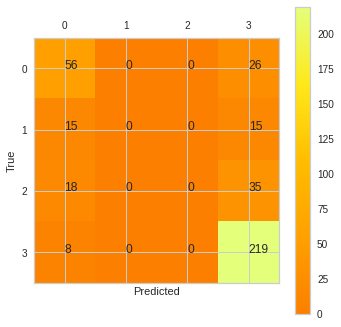

1.Cancer의 정밀도 :  57.73195876288659 %
1.Cancer의 재현율 :  68.29268292682927 %
2.Precancer의 정밀도 :  nan %
2.Precancer의 재현율 :  0.0 %
3.Inflammatory의 정밀도 :  nan %
3.Inflammatory의 재현율 :  0.0 %
4.Normal의 정밀도 :  74.23728813559322 %
4.Normal의 재현율 :  96.47577092511013 %
None


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


Test Accuracy: 68.1% (267 / 392)
Confusion Matrix:
[[ 53   0   0  29]
 [ 17   0   0  13]
 [ 28   0   0  25]
 [ 13   0   0 214]]


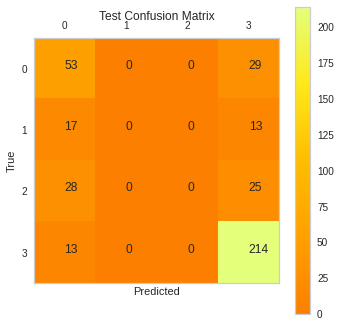

1.Cancer의 정밀도 :  47.74774774774775 %
1.Cancer의 재현율 :  64.63414634146342 %
2.Precancer의 정밀도 :  nan %
2.Precancer의 재현율 :  0.0 %
3.Inflammatory의 정밀도 :  nan %
3.Inflammatory의 재현율 :  0.0 %
4.Normal의 정밀도 :  76.15658362989323 %
4.Normal의 재현율 :  94.27312775330397 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars


ValueError: ignored

In [19]:
optimize(num_iterations=1000000)